In [1]:

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[1], 'GPU')
    print(gpu_devices[1])
    print('Success')



PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Success


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Path to your dataset
data_dir = '../Data/bone_marrow_cell_dataset'

# List to store image paths and labels
image_paths = []
labels = []

# Loop through class directories

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):
        for sub_dir_name in os.listdir(class_dir):
            sub_dir_path = os.path.join(class_dir, sub_dir_name)
            
            if os.path.isdir(sub_dir_path):
                for img_name in tqdm(os.listdir(sub_dir_path), desc=f"Processing {class_name}/{sub_dir_name}"):
                    img_path = os.path.join(sub_dir_path, img_name)
                    if os.path.isfile(img_path):
                        image_paths.append(img_path)
                        labels.append(class_name)
            else:
                img_path = os.path.join(class_dir, sub_dir_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    else:
        img_path = class_dir  # For classes without subdirectories
        if os.path.isfile(img_path):
            image_paths.append(img_path)
            labels.append(class_name)

Processing EBO/24001-25000: 100%|██████████| 1000/1000 [00:00<00:00, 180664.37it/s]


In [4]:
# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now X_train, y_train, X_val, y_val, X_test, y_test are the organized data for training, validation, and testing
# Combine all labels from train, validation, and test sets
combined_labels = y_train + y_val + y_test

# Print all unique classes
unique_classes = set(combined_labels)
print("Unique classes:", unique_classes)

Unique classes: {'MYB', 'NGB', 'PLM', 'BAS', 'PMO', 'NGS', 'LYI', 'LYT', 'BLA', 'KSC', 'EOS', 'OTH', 'EBO', 'MON', 'MMZ', 'ABE', 'PEB', 'HAC', 'NIF', 'FGC', 'ART'}


In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Calculate the number of classes directly from the labels
num_classes = len(set(combined_labels))

# Convert numerical labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

num_classes


21

In [6]:
# Change the input shape to match Xception's input shape
base_model = Xception(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


2024-02-15 05:38:50.148409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21586 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
# Preprocess images using ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rescale=1. / 255
)


batch_size = 32

# Define a custom generator to load and preprocess images on-the-fly
def custom_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for idx in indices:
            img_path = image_paths[idx]
            label = labels[idx]
            try:
                img = load_img(img_path, target_size=(250, 250))  # Resize images to VGG-16 input size
                img_array = img_to_array(img)
                batch_images.append(img_array)
                batch_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        yield np.array(batch_images), to_categorical(label_encoder.transform(batch_labels), num_classes)

In [10]:

filepath = 'Xception_weights.hdf5'
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
                  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)]

In [11]:
# Create custom generators for training, validation, and test sets
train_generator = custom_generator(X_train, y_train, batch_size)
val_generator = custom_generator(X_val, y_val, batch_size)
test_generator = custom_generator(X_test, y_test, batch_size)


In [ ]:
epochs = 10

# Train the model using the custom generator
model.fit(
    custom_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=custom_generator(X_val, y_val, batch_size),
    validation_steps=len(X_val) // batch_size,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/10


2024-02-15 05:39:36.331484: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2024-02-15 05:39:38.771903: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3748/3748 [==============================] - 1340s 356ms/step - loss: 1.0406 - accuracy: 0.7052 - val_loss: 1.9220 - val_accuracy: 0.6636

Epoch 00001: val_accuracy improved from -inf to 0.66357, saving model to Xception_weights.hdf5


/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
3748/3748 [==============================] - 1211s 323ms/step - loss: 0.6996 - accuracy: 0.8004 - val_loss: 0.8859 - val_accuracy: 0.7736

Epoch 00002: val_accuracy improved from 0.66357 to 0.77362, saving model to Xception_weights.hdf5
Epoch 3/10
3748/3748 [==============================] - 1166s 311ms/step - loss: 0.5661 - accuracy: 0.8322 - val_loss: 0.6562 - val_accuracy: 0.7974

Epoch 00003: val_accuracy improved from 0.77362 to 0.79736, saving model to Xception_weights.hdf5
Epoch 4/10
3748/3748 [==============================] - 1162s 310ms/step - loss: 0.4899 - accuracy: 0.8512 - val_loss: 0.5850 - val_accuracy: 0.8218

Epoch 00004: val_accuracy improved from 0.79736 to 0.82180, saving model to Xception_weights.hdf5
Epoch 5/10
3748/3748 [==============================] - 1163s 310ms/step - loss: 0.4255 - accuracy: 0.8718 - val_loss: 0.6290 - val_accuracy: 0.8217

Epoch 00005: val_accuracy did not improve from 0.82180
Epoch 6/10
3748/3748 [=============================

In [20]:
model.save('Xception_Model.h5')

/usr/local/lib/python3.8/dist-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [21]:
model_final = load_model('Xception_weights.hdf5')

In [24]:
# Evaluate the model on the test set using the custom generator
test_loss, test_accuracy = model_final.evaluate(
    test_generator,
    steps=len(X_test) // batch_size,
    verbose=1,
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



106/803 [==>...........................] - ETA: 1:21 - loss: 0.5992 - accuracy: 0.8308

KeyboardInterrupt: 

In [23]:

# Determine the size of the test dataset
test_size = len(X_test)

print("Total number of samples in the test dataset:", test_size)


Total number of samples in the test dataset: 25707


In [18]:

from math import ceil
from sklearn.metrics import classification_report

# Determine the size of the test dataset
test_size = len(X_test)

# Calculate the number of steps based on batch size
batch_size = 32  # Adjust according to your generator's batch size
test_steps = ceil(test_size / batch_size)

# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test generator to obtain predictions batch-wise
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model_final.predict(x_batch), axis=1))



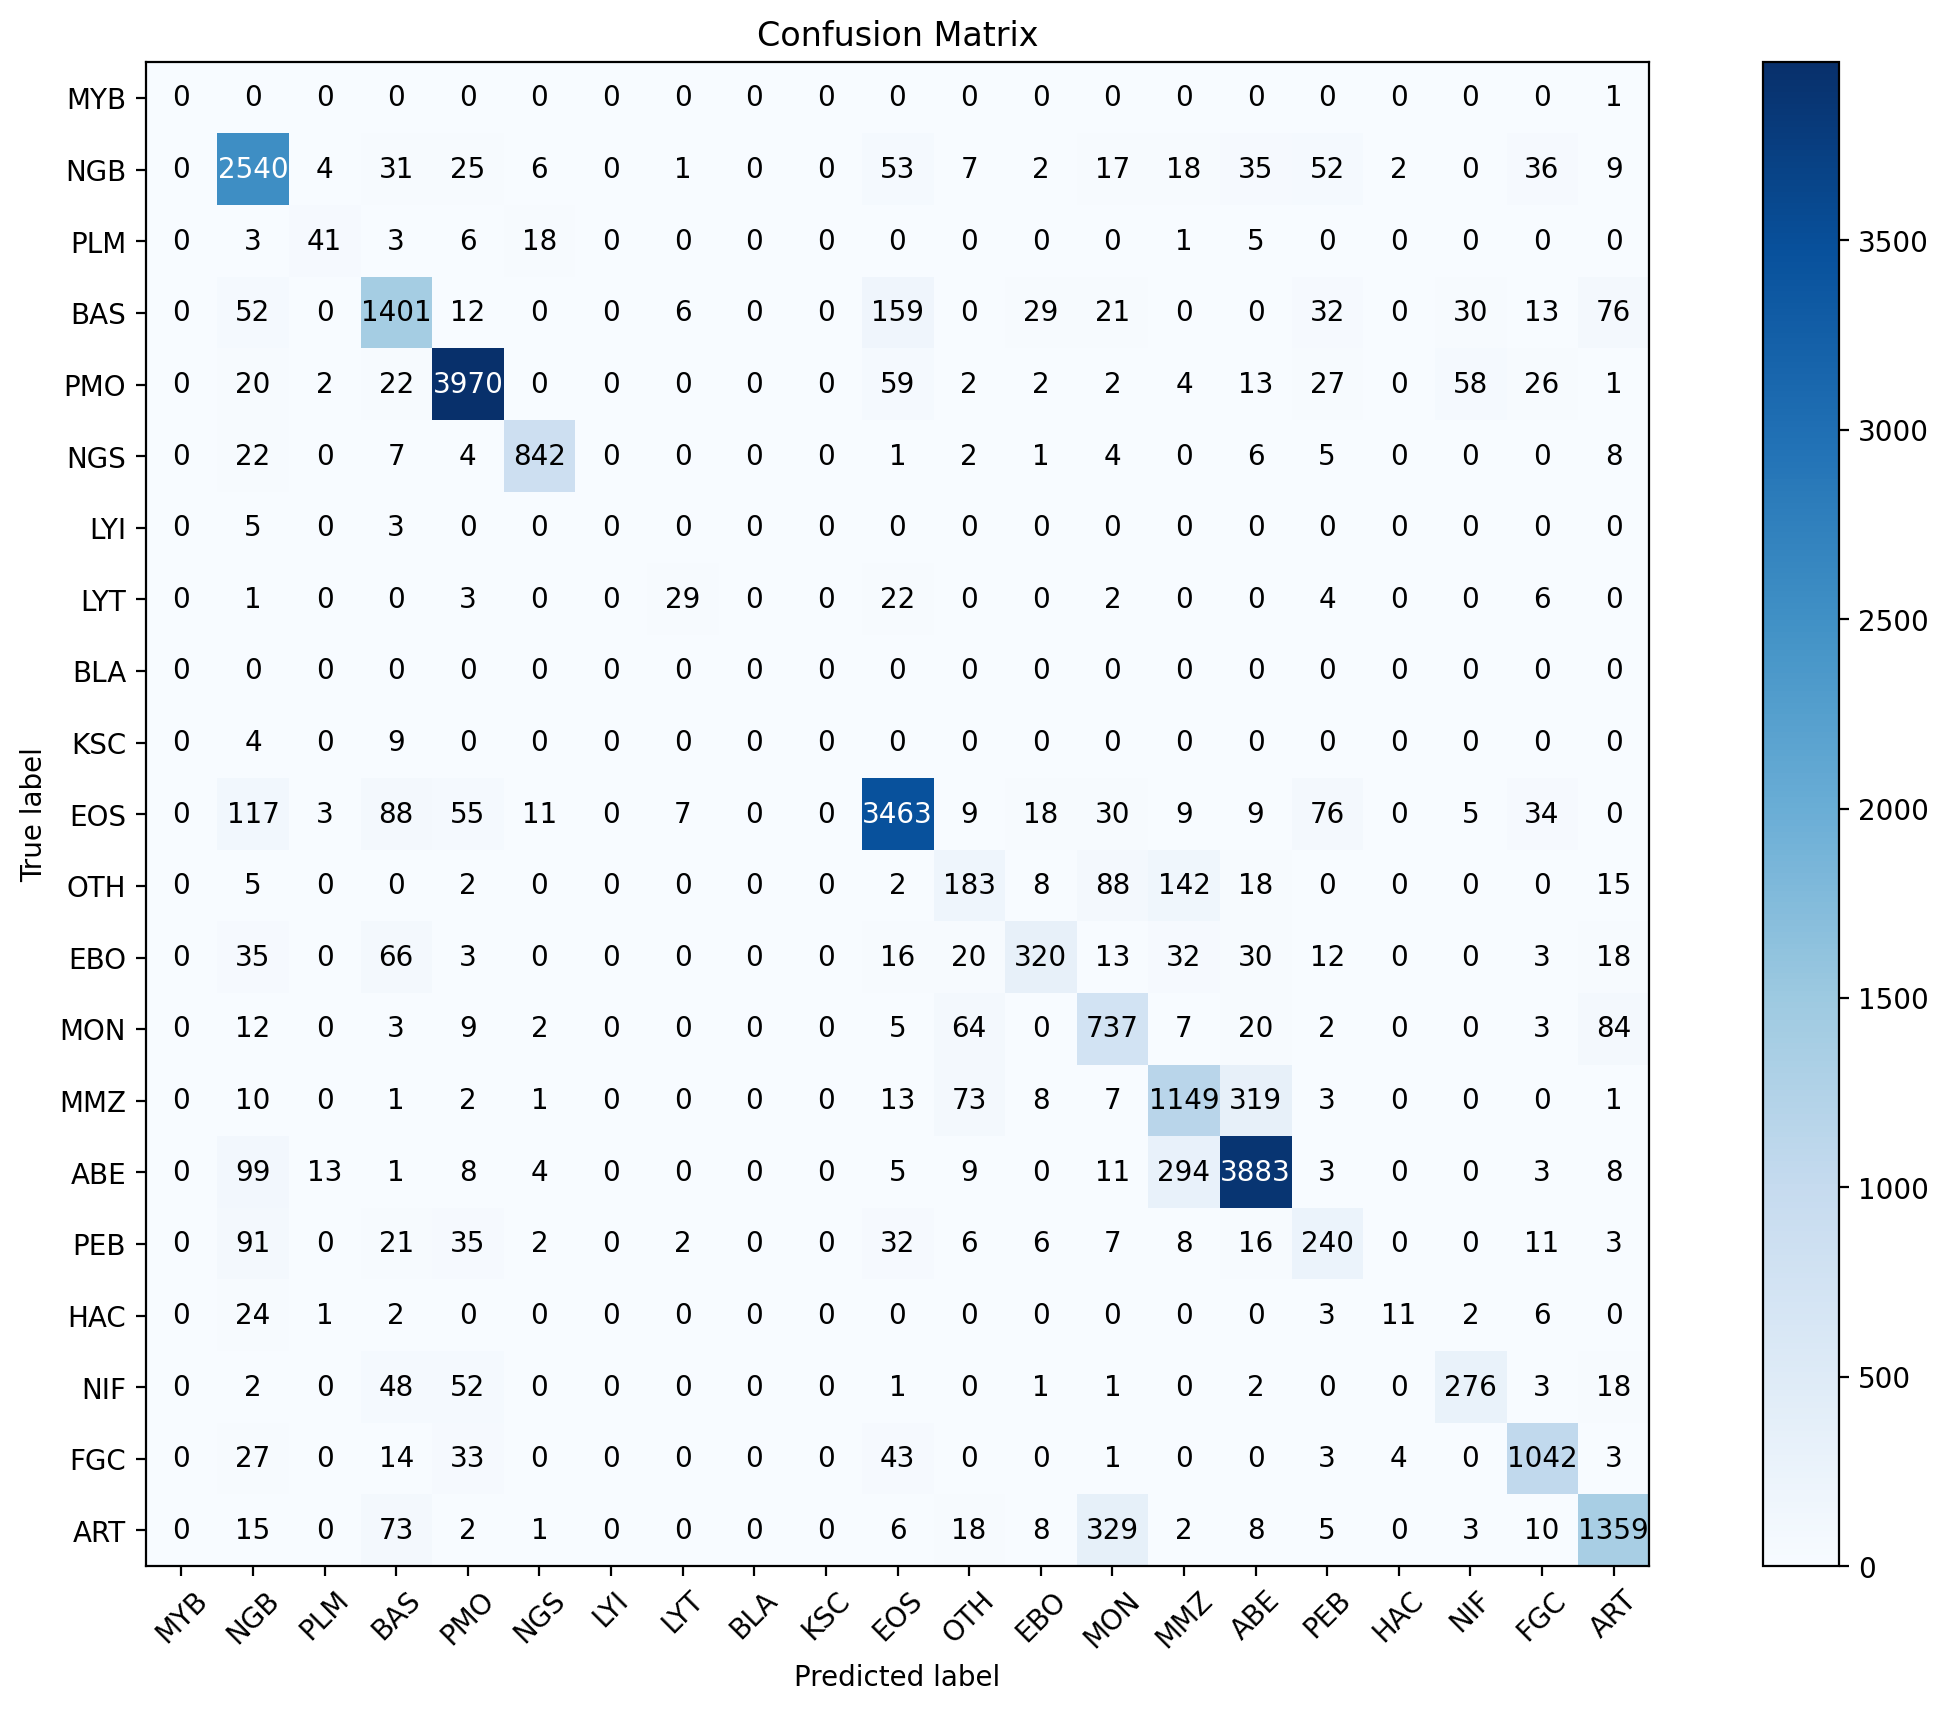

ValueError: Number of classes, 20, does not match size of target_names, 21. Try specifying the labels parameter

In [25]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get the list of all possible classes
all_classes = sorted(set(y_true + y_pred + y_train_encoded.tolist()))

# Calculate confusion matrix with all classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

# Plot confusion matrix
plt.figure(figsize=(11.7, 8.27), dpi=200)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(all_classes))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, unique_classes, rotation=45)
plt.yticks(tick_marks, unique_classes)
plt.savefig('Xception.png')
plt.show()

# Calculate classification report
class_report = classification_report(y_true, y_pred,target_names=unique_classes)

# Print classification report
print("Classification Report:")
print(class_report)


In [32]:
# Calculate classification report
class_report = classification_report(y_true, y_pred,target_names={'MYB', 'NGB', 'PLM', 'BAS', 'PMO', 'NGS', 'LYI', 'LYT', 'KSC', 'EOS', 'OTH', 'EBO', 'MON', 'MMZ', 'ABE', 'PEB', 'HAC', 'NIF', 'FGC', 'ART'})

# Print classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

         MYB       0.00      0.00      0.00         1
         NGB       0.82      0.89      0.86      2838
         PLM       0.64      0.53      0.58        77
         BAS       0.78      0.77      0.77      1831
         PMO       0.94      0.94      0.94      4208
         NGS       0.95      0.93      0.94       902
         LYI       0.00      0.00      0.00         8
         LYT       0.64      0.43      0.52        67
         KSC       0.00      0.00      0.00        13
         EOS       0.89      0.88      0.89      3934
         OTH       0.47      0.40      0.43       463
         EBO       0.79      0.56      0.66       568
         MON       0.58      0.78      0.66       948
         MMZ       0.69      0.72      0.71      1587
         ABE       0.89      0.89      0.89      4341
         PEB       0.51      0.50      0.51       480
         HAC       0.65      0.22      0.33        49
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
test_model = load_model('Xception_weights.hdf5')

2024-03-01 03:58:09.163987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 420 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6
2024-03-01 03:58:19.704753: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 128.00MiB (rounded to 134217728)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-01 03:58:19.704855: I tensorflow/core/common_runtime/bfc_allocator.cc:1013] BFCAllocator dump for GPU_0_bfc
2024-03-01 03:58:19.704898: I tensorflow/core/common_runtime/bfc_allocator.cc:1020] Bin (256): 	Total Chunks: 46, Chunks in use: 46. 11.5KiB allocated for chunks. 11.5KiB in use in bin. 1.6KiB client-requested in use in bin.
202

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [ ]:
X_test = model.test_data[0]
y_test = model.test_data[1]